In [1]:
!wget  https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl

--2020-04-16 08:05:58--  https://anaconda.org/pytorch/faiss-gpu/1.2.1/download/linux-64/faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5a15c9cc393ec612061f033a/5ac54beae586bb11ec0ace46?response-content-disposition=attachment%3B%20filename%3D%22faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27faiss-gpu-1.2.1-py36_cuda9.0.176_1.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20200416T080558Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEIj%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJHMEUCIFASARz583mcxuUYG73wQ5Q6iRTl3b7Ai06iHqyNcdhfAiEAtKSBANqI9lUoFkj2fQY4DTxJbCtIFHhTWcWHzk6H6cUqvQMIoP%2F%2F%2F%2F%2F%2F%2F%2F%

In [0]:
import numpy as np
import faiss
import dlib
import scipy.misc
import os

In [0]:
import cv2

In [0]:
#face_detector = dlib.get_frontal_face_detector()
face_detector = dlib.cnn_face_detection_model_v1("/content/drive/My Drive/Colab Notebooks/face_recognition/mmod_human_face_detector.dat")

In [0]:
shape_predictor = dlib.shape_predictor("/content/drive/My Drive/Colab Notebooks/face_recognition/shape_predictor_68_face_landmarks.dat")
#shape_predictor = dlib.shape_predictor("/content/drive/My Drive/Colab Notebooks/face_recognition/shape_predictor_5_face_landmarks.dat")

In [0]:
face_recognition_model = dlib.face_recognition_model_v1('/content/drive/My Drive/Colab Notebooks/face_recognition/dlib_face_recognition_resnet_model_v1.dat')

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
# this function returns the (128 dimension) face descriptor.
def get_face_encodings(image_path):
  image = cv2.imread(image_path)
  detected_faces = face_detector(image, 1);
  shapes_faces = [shape_predictor(image, face.rect) for face in detected_faces]
  return [np.array(face_recognition_model.compute_face_descriptor(image, face_pose, 1)) for face_pose in shapes_faces]

In [0]:
#training image names
image_filenames = os.listdir("/content/drive/My Drive/Colab Notebooks/face_recognition/faces/")

In [0]:
# paths to all training images.
paths_to_images = ["/content/drive/My Drive/Colab Notebooks/face_recognition/faces/" + x for x in image_filenames]

In [0]:
# for each face per image 128 dimensional vector is stored in face_encodings
face_encodings = []

In [0]:
for path_to_image in paths_to_images:
  face_descriptor = get_face_encodings(path_to_image)
  if len(face_descriptor) == 0:
    print("No face to recognige in this picture")
    exit()
  if len(face_descriptor) != 1:
    print("there are more faces in the image. restrict to one face per image")
    exit()
  face_encodings.append(face_descriptor[0])

In [13]:
len(face_encodings)

31

In [14]:
face_encodings[28].shape

(128,)

In [15]:
type(face_encodings[2][3])      

numpy.float64

In [0]:
vectors = face_encodings

In [0]:
vectors = np.array(vectors).astype('float32')

In [18]:
type(vectors[0][0])

numpy.float32

In [19]:
vectors.shape

(31, 128)

In [0]:
dimension = 128     #dimension of feature vector of image 
no_of_vectors = 31  # number of training images

In [0]:
no_of_clusters = 3        #number of clusters
quantiser = faiss.IndexFlatL2(dimension)
index = faiss.IndexIVFFlat(quantiser, dimension, no_of_clusters, faiss.METRIC_L2)

In [0]:
index.train(vectors)

In [23]:
index.ntotal

0

In [0]:
index.add(vectors)

In [25]:
index.ntotal

31

In [0]:
nprobe = 1          # nprobe tells how many similar clusters to be searched(should be less than no. of clusters)  
n_query = 2         # no. of query images
k = 1               # return 1 nearest image

In [0]:
#to store feature vectors of query images to be searched 
query_vectors = []

In [0]:
query_vectors.append(get_face_encodings("/content/drive/My Drive/Colab Notebooks/face_recognition/test/images.jpeg")[0].astype('float32'))

In [0]:
query_vectors.append(get_face_encodings("/content/drive/My Drive/Colab Notebooks/face_recognition/test/img6.jpeg")[0].astype('float32'))

In [0]:
query_vectors = np.array(query_vectors)

In [0]:
distances, indices = index.search(query_vectors, k)

In [45]:
distances

array([[0.16460562],
       [0.19733408]], dtype=float32)

In [46]:
indices

array([[24],
       [ 0]])

In [0]:
def show_image(image_path, name):
  image = cv2.imread(image_path)
  detected_faces = face_detector(image, 1);
  for face in detected_faces:
    face_rect = face.rect
    x1 = face_rect.left()
    y1 = face_rect.top()
    x2 = face_rect.right() + 1
    y2 = face_rect.bottom() + 1
    cv2.rectangle(image, (x1,y1) ,(x2, y2), (0,0,255), 2)
    cv2.putText(image, name, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX ,  0.7, (0,0, 255), 1, cv2.LINE_AA) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  imgplot = plt.imshow(image)

In [48]:
# name of query image 1
image_filenames[indices[0][0]]

'sudhamurthy.jpg'

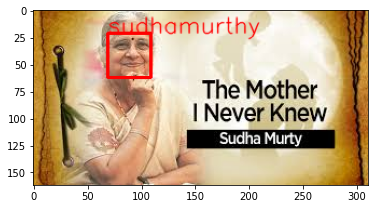

In [49]:
show_image("/content/drive/My Drive/Colab Notebooks/face_recognition/test/images.jpeg", image_filenames[indices[0][0]][:-4])

In [50]:
# name of query image 2
image_filenames[indices[1][0]]

'abhinandhan.jpg'

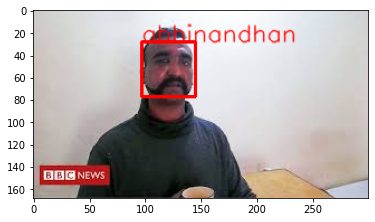

In [51]:
show_image("/content/drive/My Drive/Colab Notebooks/face_recognition/test/img6.jpeg", image_filenames[indices[1][0]][:-4])